In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# 1. Load Data
# Note: Use your local path or the CSV filename
file_path = r"C:\Users\Alex.Maingi\Downloads\Verified_ A1_Positive_indicators_Verified.xlsx"
df = pd.read_excel(file_path)
# Display the first few rows to confirm it worked
df.head()

,Plant species group,Plant species,Habitat type (Dry/wet/marsh….etc),Fossit Classification,Color of flower,Flowering period of year,Jan,Feb,March,April,May,June,July,Aug,Sep,Oct,Nov,Dec
0,NaN,Birdʼs-foot-trefoil,"Roadsides, sandhills, stone-walls, grass",GS2 (Dry meadows and grassy verges),"Bright yellow, red/orange",June–September,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN
1,NaN,Carline thistle,Birdʼs-foot-trefoil,"Dry calcareous and neutral grassland (GS1), CD...","Golden-brown, tinged purple",June–September,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN
2,NaN,Cowslip,Common in Meadows on basic and calaaceous soils,(GS1) Dry calcareous and neutral grassland; (G...,"rich, deep yellow, often described as egg-yolk...",April-May,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Primrose,Common in woods and shady banks,WN2 (Oak-ash-hazel woodland); WN2 (Oak-ash-haz...,ale to deep yellow with darker yellow-orange c...,Feb-May,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Eye Bright,"Dry, calcareous (limestone) grassland",GS1 Dry calcareous and neutral grassland (GS1),White,July–August,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN


In [3]:
# 2. Setup Months
months = ["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [4]:
# 3. Data-Driven Habitat Categorization
def categorize_habitat_strict(row):
    h = (str(row["Habitat type (Dry/wet/marsh….etc)"]) + " " + 
         str(row["Fossit Classification"])).lower()
    
    if any(k in h for k in ['heath', 'moor', 'bog', 'acid', 'pb', 'hh', 'gs3', 'peaty']):
        return "Heaths, Bogs & Acidic Ground"
    if any(k in h for k in ['wet', 'marsh', 'damp', 'moist', 'gs4', 'gm', 'fen', 'flush', 'soggy', 'ditch', 'turlough', 'pond', 'pf']):
        return "Wetland, Marsh & Fen"
    if any(k in h for k in ['wood', 'shade', 'wn', 'wl', 'hedge', 'thicket', 'scrub', 'bank']):
        return "Woodland & Hedgerows"
    if any(k in h for k in ['dune', 'marram', 'cd', 'machair', 'coastal', 'sandhill']):
        return "Coastal & Dunes"
    if any(k in h for k in ['arable', 'waste', 'bc', 'ed', 'refuse', 'garden']):
        return "Arable & Waste Ground"
    return "Dry Meadows & Grassland"

df = df[df["Plant species"].notna()].copy()
df["Habitat_Group"] = df.apply(categorize_habitat_strict, axis=1)

In [5]:
# 4. Process Flowering Data (including Moss correction)
for m in months:
    df[m] = pd.to_numeric(df[m], errors='coerce').notna().astype(int)

df["Start_num"] = df[months].apply(lambda x: x.values.argmax() + 1 if x.any() else 0, axis=1)
df["End_num"] = df[months].apply(lambda x: len(months) - x.values[::-1].argmax() if x.any() else 0, axis=1)
df["Duration"] = df["End_num"] - df["Start_num"] + 1

# Handle non-flowering mosses as year-round visible indicators
mask_moss = df["Plant species"].str.contains("moss", case=False, na=False)
df.loc[mask_moss, ["Start_num", "End_num", "Duration"]] = [1, 12, 12]

df = df[df["Duration"] > 0].copy()

In [6]:
# 5. NEW: Refined "Distinct" Color Mapping based on Excel Descriptions
def get_distinct_color(row):
    color_text = str(row['Color of flower']).lower()
    species_text = str(row['Plant species']).lower()

    # Moss special case (Peatland/Sphagnum colors)
    if 'moss' in species_text: return "#D2691E" # Sphagnum Orange-Brown

    # Specific descriptive matches (High Priority)
    if 'egg-yolk' in color_text: return "#FFBF00" # Deep rich yellow
    if 'lemon' in color_text: return "#FAFA33"
    if 'golden' in color_text: return "#FFD700"
    if 'cream' in color_text or 'creamy' in color_text: return "#FFFDD0"
    if 'magenta' in color_text: return "#FF00FF"
    if 'maroon' in color_text: return "#800000"
    if 'crimson' in color_text: return "#DC143C"
    if 'lilac' in color_text: return "#C8A2C8"
    if 'mauve' in color_text: return "#E0B0FF"
    if 'sky blue' in color_text or 'forget-me-not' in color_text: return "#87CEEB"
    if 'pure blue' in color_text or 'harebell' in species_text: return "#0000FF"
    if 'blue-violet' in color_text: return "#8A2BE2"
    if 'shell pink' in color_text: return "#F3C1D3"
    if 'deep pink' in color_text: return "#FF1493"

    # General color keywords (Ordered for Bird's-foot-trefoil & others)
    if 'yellow' in color_text: return "#F2C94C"
    if 'purple' in color_text: return "#9B59B6"
    if 'blue' in color_text: return "#3498DB"
    if 'pink' in color_text: return "#EC7063"
    if 'red' in color_text: return "#C0392B"
    if 'white' in color_text: return "#FEF9E7"
    if 'green' in color_text: return "#52BE80"
    if 'brown' in color_text: return "#8B4513"

    return "#BDC3C7" # Fallback Gray

df["Bar_Color"] = df.apply(get_distinct_color, axis=1)

In [9]:
# 6. Sorting
df = df.sort_values(["Habitat_Group", "Start_num"]).reset_index(drop=True)
df["y"] = range(len(df))
habitat_breaks = df["Habitat_Group"].ne(df["Habitat_Group"].shift())
break_positions = df.loc[habitat_breaks, "y"].tolist()

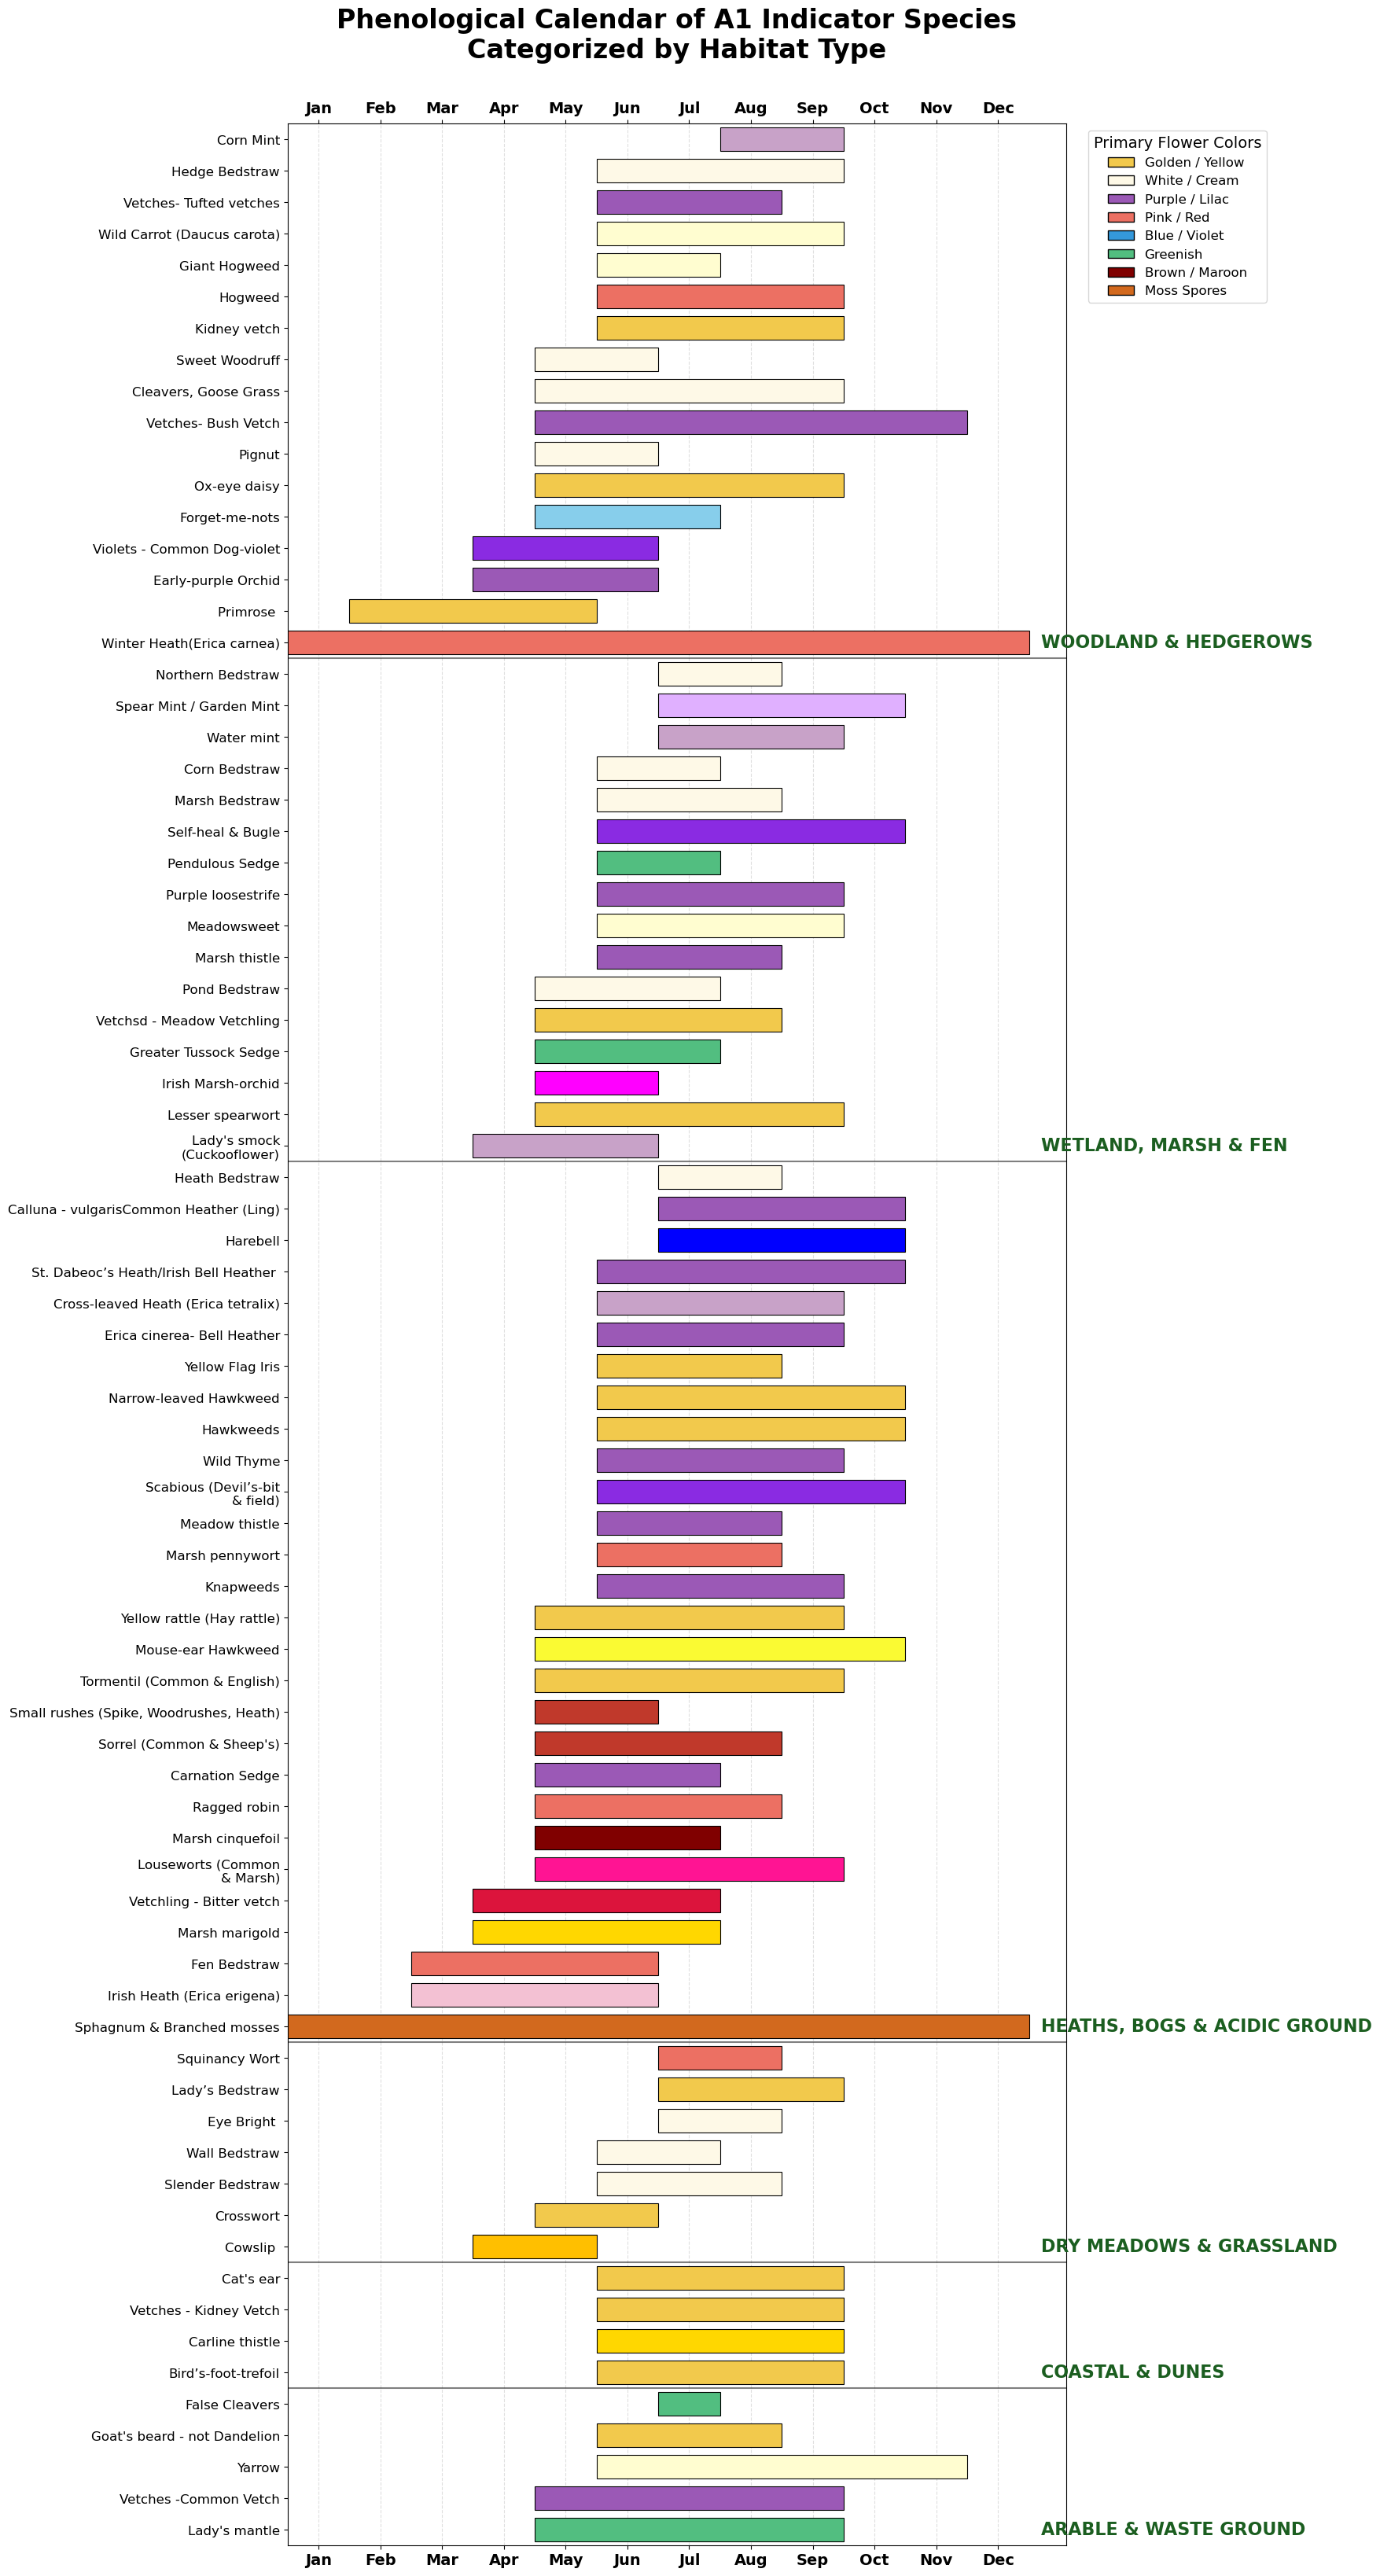

In [10]:
# 7. Final Plotting
plt.rcParams.update({'font.size': 14}) # Global increase
fig, ax = plt.subplots(figsize=(18, len(df) * 0.5)) # Slightly increased height per row

ax.barh(df["y"], df["Duration"], left=df["Start_num"] - 0.5, 
        color=df["Bar_Color"], height=0.75, edgecolor='black', linewidth=0.8, zorder=3)

# Habitat Group Labels - Increased Font & Weight
for i, y in enumerate(break_positions):
    if i > 0: ax.axhline(y - 0.5, color="black", linewidth=1.5, alpha=0.5, zorder=2)
    group_name = df.loc[df["y"] == y, "Habitat_Group"].iloc[0]
    ax.text(12.7, y, group_name.upper(), va='center', ha='left', 
            fontsize=16, fontweight='bold', color='#1B5E20') # Increased from 13

# X-Axis Layout - Increased Month Labels
ax.set_xticks(range(1, 13))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"], 
                   fontsize=14, fontweight='bold') # Increased from 11
ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)

# Y-Axis Layout - Increased Species Names
ax.set_yticks(df["y"])
ax.set_yticklabels(df["Plant species"], fontsize=12) # Increased from 10

# Legend Adjustments
color_legend_data = {
    "Golden / Yellow": "#F2C94C", "White / Cream": "#FEF9E7", "Purple / Lilac": "#9B59B6", 
    "Pink / Red": "#EC7063", "Blue / Violet": "#3498DB", "Greenish": "#52BE80", 
    "Brown / Maroon": "#800000", "Moss Spores": "#D2691E"
}
# FIX for the UserWarning: use facecolor instead of color
legend_patches = [mpatches.Patch(facecolor=v, label=k, edgecolor='black') for k, v in color_legend_data.items()]
ax.legend(handles=legend_patches, title="Primary Flower Colors", 
          bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12, title_fontsize=14)

ax.set_ylim(len(df) - 0.5, -0.5)
ax.invert_yaxis()
ax.grid(axis='x', linestyle='--', alpha=0.4, zorder=0)

plt.title("Phenological Calendar of A1 Indicator Species\nCategorized by Habitat Type", 
          fontsize=24, fontweight='bold', pad=60) # Increased from 20

plt.subplots_adjust(left=0.25, right=0.80, top=0.88, bottom=0.08) # Adjusted for larger fonts

# --- EXPORT TO PDF ---
save_path = r"C:\Users\Alex.Maingi\Downloads\Phenological_Calendar_A1_Journal_Quality.pdf"
plt.savefig(save_path, bbox_inches='tight', dpi=600) # Increased DPI to 600 for RS Journal
plt.show()

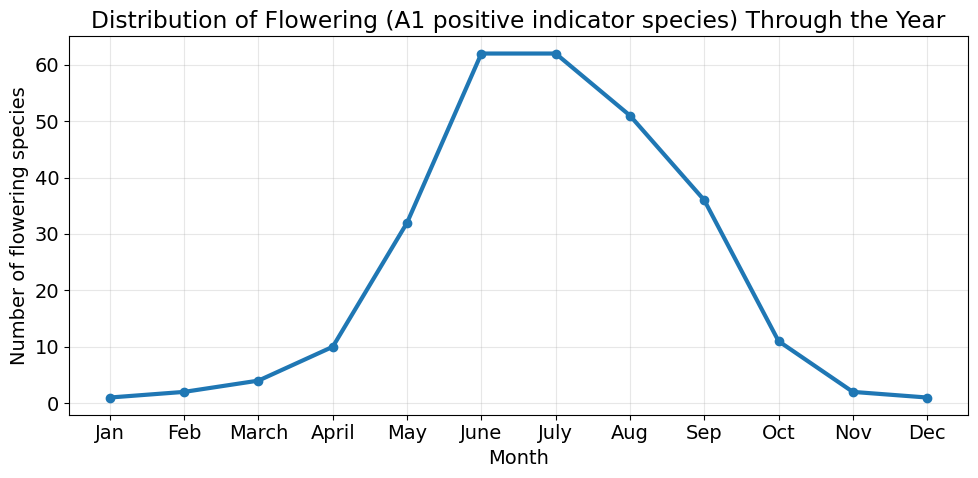

In [8]:
# Count flowering species per month
flowering_per_month = df[months].sum()

plt.figure(figsize=(10, 5))

plt.plot(
    months,
    flowering_per_month,
    marker='o',
    linewidth=3
)

plt.xlabel("Month")
plt.ylabel("Number of flowering species")
plt.title("Distribution of Flowering (A1 positive indicator species) Through the Year")

plt.grid(alpha=0.3)
plt.tight_layout()

# SAVE IT HERE 👇
plt.savefig(
    r"C:\Users\Alex.Maingi\Downloads\flowering_distribution.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()